In [1]:
from fastai.vision.all import *
import fastai
import timm
import torch
import albumentations as A
transform = A.load("/media/newhd/OPTRetina/DMAE/autoalbument-amd/outputs/2021-11-24/10-32-22/policy/latest.json")

In [2]:
torch.cuda.set_device(3)

In [3]:
df = pd.read_csv('../trainValid.csv')

In [4]:
df

,Unnamed: 0,nombre_foto,grado de DMAE,binary,set
0,61504,anonymized_231059.jpg,normal,0,training
1,176989,anonymized_442122.jpg,normal,0,training
2,133399,anonymized_363034.jpg,normal,0,training
3,220150,anonymized_519072.jpg,normal,0,training
4,155853,anonymized_403989.jpg,normal,0,training
...,...,...,...,...,...
7797,224854,anonymized_528388.jpg,tardia,1,validation
7798,225492,anonymized_529721.jpg,intermedia,1,validation
7799,226322,anonymized_531350.jpg,precoz,1,validation
7800,227489,anonymized_533460.jpg,tardia,1,validation


In [5]:
def is_valid(path):
    name = path[1]
    return (df[df['nombre_foto']==name])['set'].values[0]=='validation'

# 224

In [6]:
class AlbumentationsTransform(Transform):
    def __init__(self, aug): self.aug = aug
    def encodes(self, img: PILImage):
        aug_img = self.aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

In [13]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=5),
    SaveModelCallback(fname='inceptionv4_224_b',monitor='f1_score'),
    #ReduceLROnPlateau(patience=2)
]

In [14]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_valid),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(384),AlbumentationsTransform(transform[0])], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=224, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [15]:
dls = db.dataloaders(df.values,bs=128,num_workers=0)

In [16]:
learn = Learner(dls,timm.create_model('inception_v4',num_classes=2,pretrained=True,drop_rate=0.5),
                metrics=[accuracy,Precision(),Recall(),F1Score(),RocAucBinary()],
                cbs=callbacks,
                loss_func= FocalLossFlat()).to_fp16()

SuggestedLRs(valley=0.00019054606673307717)

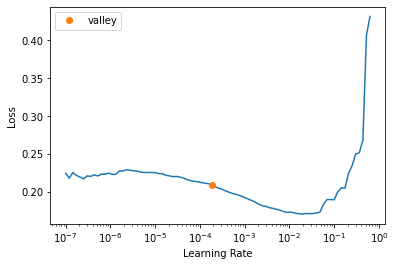

In [11]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.125910,0.265040,0.810256,0.759657,0.907692,0.827103,0.889027,01:56


Better model found at epoch 0 with f1_score value: 0.8271028037383179.


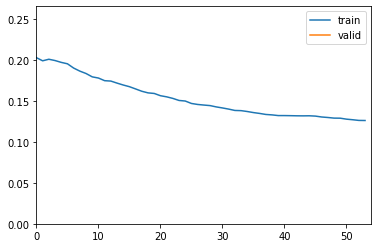

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.102619,0.085303,0.838462,0.934211,0.728205,0.818444,0.939250,01:56
1,0.094327,0.098581,0.841026,0.891176,0.776923,0.830137,0.923600,01:55
2,0.090435,0.082974,0.855128,0.883657,0.817949,0.849534,0.941670,01:56
3,0.087246,0.085926,0.843590,0.831683,0.861538,0.846348,0.935651,01:57
4,0.084734,0.085791,0.869231,0.861809,0.879487,0.870558,0.936160,01:57
5,0.083811,0.088193,0.850000,0.843829,0.858974,0.851334,0.934274,01:54
6,0.081995,0.077888,0.876923,0.884817,0.866667,0.875648,0.945947,01:52
7,0.081622,0.070006,0.879487,0.854067,0.915385,0.883663,0.957416,01:56
8,0.080355,0.086954,0.869231,0.909091,0.820513,0.862534,0.941272,01:57
9,0.079087,0.092548,0.844872,0.885387,0.792308,0.836265,0.934892,01:57


Better model found at epoch 0 with f1_score value: 0.8184438040345822.


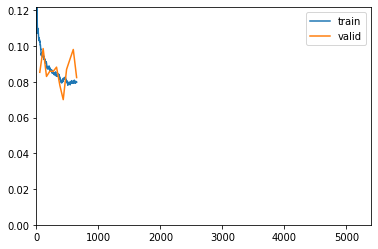

Better model found at epoch 1 with f1_score value: 0.8301369863013699.
Better model found at epoch 2 with f1_score value: 0.8495339547270306.
Better model found at epoch 4 with f1_score value: 0.8705583756345178.
Better model found at epoch 6 with f1_score value: 0.8756476683937824.
Better model found at epoch 7 with f1_score value: 0.8836633663366337.
No improvement since epoch 7: early stopping


In [17]:
learn.fine_tune(100,base_lr=3e-3)

In [18]:
dfTest = pd.read_csv('../testSample.csv')

In [19]:
def is_test(path):
    name = path[1]
    return (dfTest[dfTest['nombre_foto']==name])['set'].values[0]=='test'

In [20]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_test),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(384)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=224, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [21]:
dlsTest = dbTest.dataloaders(dfTest.values,bs=64,num_workers=0)

In [22]:
learn.dls = dlsTest

In [23]:
learn.validate()

Better model found at epoch 0 with f1_score value: 0.9547855358316897.


(#6) [0.0848144069314003,0.8989743590354919,0.9026915113871635,0.8943589743589744,0.8985059247810406,0.9547855358316897]

# 384

In [49]:
import torch
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=5),
    SaveModelCallback(fname='inceptionv4_384_b',monitor='f1_score'),
    #ReduceLROnPlateau(patience=2)
]

In [50]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_valid),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(512),AlbumentationsTransform(transform[0])], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=384, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [51]:
dls = db.dataloaders(df.values,bs=32,num_workers=0)

In [52]:
learn = Learner(dls,timm.create_model('inception_v4',num_classes=2,pretrained=True,drop_rate=0.5),
                metrics=[accuracy,Precision(),Recall(),F1Score(),RocAucBinary()],
                cbs=callbacks,
                loss_func= FocalLossFlat()).to_fp16()

In [53]:
learn.load('inceptionv4_224_b')

/home/jonathan/.virtualenvs/segmentation/lib/python3.6/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


SuggestedLRs(valley=0.0005754399462603033)

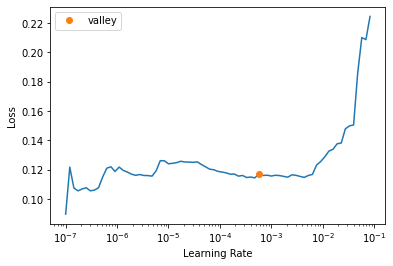

In [54]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.106489,0.298622,0.752564,0.912134,0.558974,0.693164,0.887640,02:35


Better model found at epoch 0 with f1_score value: 0.6931637519872813.


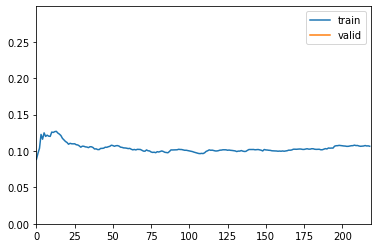

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.096529,0.088529,0.844872,0.926984,0.748718,0.828369,0.939872,02:40
1,0.088402,0.087112,0.843590,0.889535,0.784615,0.833787,0.935855,02:45
2,0.086210,0.079197,0.864103,0.920118,0.797436,0.854396,0.949346,02:45
3,0.079287,0.081256,0.857692,0.873995,0.835897,0.854522,0.940815,02:45
4,0.072938,0.073659,0.873077,0.896458,0.843590,0.869221,0.952291,02:44
5,0.079422,0.074756,0.874359,0.898907,0.843590,0.870370,0.954096,02:44
6,0.080165,0.072751,0.867949,0.897507,0.830769,0.862850,0.952913,02:43
7,0.078893,0.077004,0.882051,0.886010,0.876923,0.881443,0.948383,02:46
8,0.075907,0.078668,0.871795,0.875648,0.866667,0.871134,0.946716,02:45
9,0.078703,0.083368,0.874359,0.926901,0.812821,0.866120,0.949099,02:45


Better model found at epoch 0 with f1_score value: 0.8283687943262412.


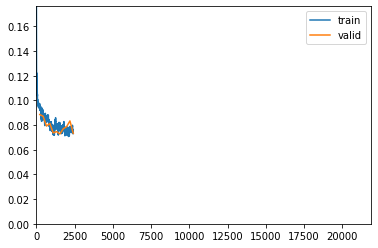

Better model found at epoch 1 with f1_score value: 0.8337874659400544.
Better model found at epoch 2 with f1_score value: 0.8543956043956046.
Better model found at epoch 3 with f1_score value: 0.854521625163827.
Better model found at epoch 4 with f1_score value: 0.869220607661823.
Better model found at epoch 5 with f1_score value: 0.8703703703703705.
Better model found at epoch 7 with f1_score value: 0.8814432989690721.
Better model found at epoch 10 with f1_score value: 0.8860103626943004.
No improvement since epoch 6: early stopping


In [55]:
learn.fine_tune(100,base_lr=1e-3)

In [56]:
dfTest = pd.read_csv('../testSample.csv')

In [57]:
def is_test(path):
    name = path[1]
    return (dfTest[dfTest['nombre_foto']==name])['set'].values[0]=='test'

In [58]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_test),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(512)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=384, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [59]:
dlsTest = dbTest.dataloaders(dfTest.values,bs=64,num_workers=0)

In [60]:
learn.dls = dlsTest

In [61]:
learn.validate()

Better model found at epoch 0 with f1_score value: 0.9619534516765285.


(#6) [0.06990386545658112,0.9025641083717346,0.922497308934338,0.8789743589743589,0.9002100840336134,0.9619534516765285]

# 512

In [62]:
import torch
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=5),
    SaveModelCallback(fname='inceptionv4_512',monitor='f1_score'),
    #ReduceLROnPlateau(patience=2)
]

In [63]:
import torch
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=5),
    SaveModelCallback(fname='inceptionv4_512_b',monitor='f1_score'),
    #ReduceLROnPlateau(patience=2)
]

In [64]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_valid),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(640),AlbumentationsTransform(transform[0])], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=512, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [65]:
dls = db.dataloaders(df.values,bs=8,num_workers=0)

In [66]:
learn = Learner(dls,timm.create_model('inception_v4',num_classes=2,pretrained=True,drop_rate=0.5),
                metrics=[accuracy,Precision(),Recall(),F1Score(),RocAucBinary()],
                cbs=callbacks,
                loss_func= FocalLossFlat()).to_fp16()

In [67]:
learn.load('inceptionv4_384_b')

/home/jonathan/.virtualenvs/segmentation/lib/python3.6/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.195337,0.178656,0.515385,0.508746,0.894872,0.648699,0.476976,05:35


Better model found at epoch 0 with f1_score value: 0.6486988847583643.


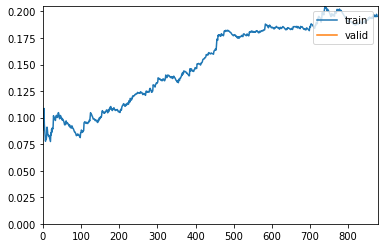

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.175964,0.173034,0.548718,0.530844,0.838462,0.650099,0.550763,05:21
1,0.175616,0.174098,0.561538,0.537500,0.882051,0.667961,0.549596,05:24
2,0.171846,0.169483,0.585897,0.561694,0.782051,0.653805,0.595039,05:41
3,0.172544,0.168455,0.602564,0.577220,0.766667,0.658590,0.631696,05:43
4,0.171198,0.169371,0.602564,0.563492,0.910256,0.696078,0.655615,05:42
5,0.153214,0.140383,0.730769,0.750000,0.692308,0.720000,0.808205,05:39
6,0.146250,0.137860,0.738462,0.829787,0.600000,0.696429,0.842988,05:33
7,0.138888,0.131785,0.743590,0.769886,0.694872,0.730458,0.829349,05:41
8,0.129106,0.118196,0.782051,0.754630,0.835897,0.793187,0.877055,05:43
9,0.141204,0.151141,0.712821,0.792254,0.576923,0.667656,0.802541,05:37


Better model found at epoch 0 with f1_score value: 0.6500994035785288.


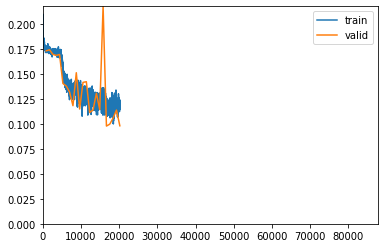

Better model found at epoch 1 with f1_score value: 0.6679611650485436.
Better model found at epoch 4 with f1_score value: 0.696078431372549.
Better model found at epoch 5 with f1_score value: 0.7199999999999999.
Better model found at epoch 7 with f1_score value: 0.7304582210242588.
Better model found at epoch 8 with f1_score value: 0.7931873479318735.
Better model found at epoch 12 with f1_score value: 0.7948717948717948.
Better model found at epoch 17 with f1_score value: 0.8053204353083434.
Better model found at epoch 19 with f1_score value: 0.8060522696011005.
Better model found at epoch 23 with f1_score value: 0.8124191461836997.
No improvement since epoch 18: early stopping


In [68]:
learn.fine_tune(100,base_lr=3e-3)

In [69]:
dfTest = pd.read_csv('../testSample.csv')

In [70]:
def is_test(path):
    name = path[1]
    return (dfTest[dfTest['nombre_foto']==name])['set'].values[0]=='test'

In [71]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_test),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(640)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=512, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [72]:
dlsTest = dbTest.dataloaders(dfTest.values,bs=8,num_workers=0)

In [73]:
learn.dls = dlsTest

In [74]:
learn.validate()

Better model found at epoch 0 with f1_score value: 0.9176184089414859.


(#6) [0.10365241765975952,0.8523076772689819,0.8530318602261048,0.8512820512820513,0.8521560574948664,0.9176184089414859]